In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d 
from sklearn import datasets
from sklearn.neighbors.kde import KernelDensity

# Binary classification by logistic regression

Text(-10.0, 0.5, '$\\sigma(z)=1/(1+\\exp(-z))$')

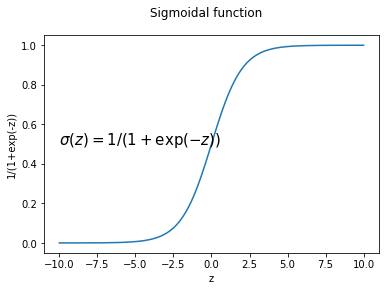

In [3]:
xv=np.linspace(-10,10,100)
yv=1/(1+np.exp(-xv))
# logistic function 
fig = plt.figure()
# draw the figure about the sigmoidal function
fig.suptitle('Sigmoidal function')
ax = fig.add_subplot(111)
ax.plot(xv,yv)
ax.set_xlabel('z')
ax.set_ylabel('1/(1+exp(-z))')
ax.text(-10.,0.5, r'$\sigma(z)=1/(1+\exp(-z))$', fontsize=15)

# this celll is used to draw the figure of the function 

In [5]:
df = pd.read_csv('./Default.csv')
df.head()
# here use the pandas library to read the csv file.

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


In [6]:
df.replace({'No':0},inplace=True)
df.replace({'Yes':1},inplace=True)
df.head()
# use the pandas replace to label the attrs

,Unnamed: 0,default,student,balance,income
0,1,0,0,729.526495,44361.625074
1,2,0,1,817.180407,12106.134700
2,3,0,0,1073.549164,31767.138947
3,4,0,0,529.250605,35704.493935
4,5,0,0,785.655883,38463.495879


Red points are for defaulters, green for non-defaulters.


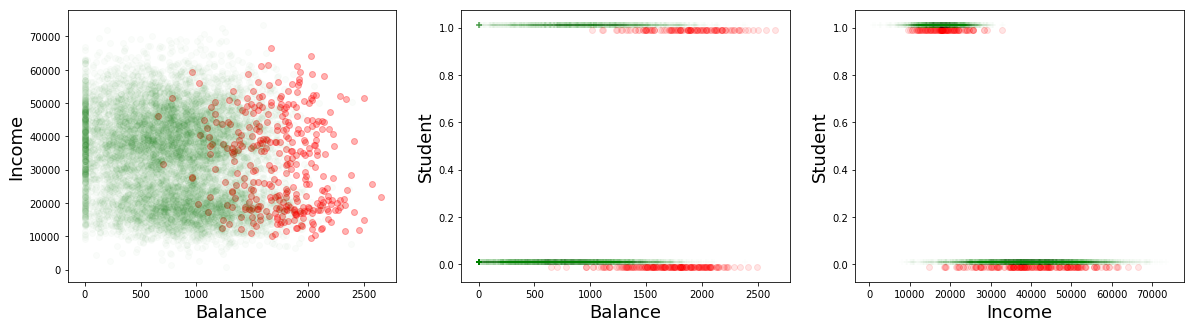

In [13]:
# a quick look at the scatter plot to determine features

fig, ax = plt.subplots(figsize=(20,5),nrows=1, ncols=3)

ax[0].scatter(df[df['default']==1]['balance'], df[df['default']==1]['income'], c='r', alpha=0.3)
ax[0].scatter(df[df['default']==0]['balance'], df[df['default']==0]['income'], c='g', alpha=0.02)
ax[0].set_xlabel('Balance', fontsize=18)
ax[0].set_ylabel('Income', fontsize=18)

ax[1].scatter(df[df['default']==1]['balance'], df[df['default']==1]['student']-0.01, c='r', marker = 'o', alpha=0.1)
ax[1].scatter(df[df['default']==0]['balance'], df[df['default']==0]['student']+0.01, c='g',marker = '+', alpha=0.01)
ax[1].set_xlabel('Balance', fontsize=18)
ax[1].set_ylabel('Student', fontsize=18)

ax[2].scatter(df[df['default']==1]['income'], df[df['default']==1]['student']-0.01, c='r', marker = 'o', alpha=0.1)
ax[2].scatter(df[df['default']==0]['income'],df[df['default']==0]['student']+0.01, c='g',marker = '+', alpha=0.01)
ax[2].set_xlabel('Income', fontsize=18)
ax[2].set_ylabel('Student', fontsize=18)
# + - 0.01 is to make it clear, avoiding the overlapping.

print("Red points are for defaulters, green for non-defaulters.")
# 1 means it's student, 0 means it's not students

In [17]:
# To minimise typing out different slices of the DataFrame, define:
defaulters = df[df['default']==1]
nondefaulters  = df[df['default']==0]
# print(defaulters,nondefaulters)

Histograms of defaulters (red) and non-defaulters (green).
      (Aside:) income distributions are bimodal.


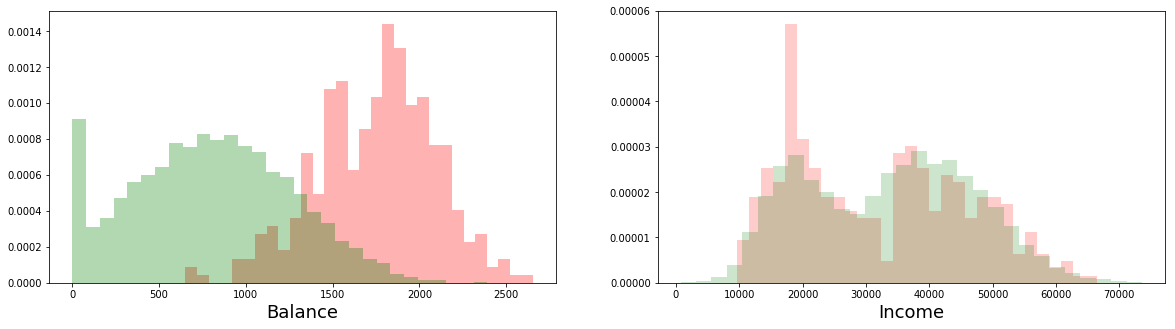

In [18]:
fig, ax = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
# draw two plots

ax[0].hist(defaulters.balance, bins=30, density=True, color='r', alpha=0.3)
ax[0].hist(nondefaulters.balance, bins=30, density=True, color='g', alpha=0.3)
ax[0].set_xlabel('Balance', fontsize=18)

ax[1].hist(defaulters.income, bins=30, density=True, color='r', alpha=0.2)
ax[1].hist(nondefaulters.income, bins=30, density=True, color='g', alpha=0.2)
ax[1].set_xlabel('Income', fontsize=18)
print("Histograms of defaulters (red) and non-defaulters (green).\n\
      (Aside:) income distributions are bimodal.")
# 画出直方图来看defaulter和nondefaulters的相关分布

In [19]:
binedge=np.linspace(0,2700-5,50) 
# we will place the data in 50 bins
mid=np.mean((binedge[1:]-binedge[:-1])/2) 
# identify bins by their mid-points
binmid=binedge[:-1]+mid

# create histograms for defaulters and non-defaulters
# these correspond to P(balance|default == 1) and P(balance| default == 0)
defhist=np.histogram(defaulters['balance'], bins=binedge, density="True")
nondefhist=np.histogram(nondefaulters['balance'], bins=binedge, density="True")

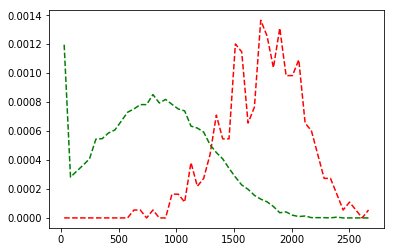

In [20]:
# we display the (x,y) values of (balance, prob())
x_grid = binmid
defhist1=defhist[0] # just keep the values in each bin
nondefhist1=nondefhist[0] # just keep the values in each bin
plt.plot(x_grid,defhist1, 'r--')
plt.plot(x_grid,nondefhist1, 'g--')

# 由直方图画出了折线图

## A detour: constructing a pdf from a histogram

[55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55.
 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55.
 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55. 55.]
Cumulative probability  [1.0000000000000002, 1.0000000000000002]


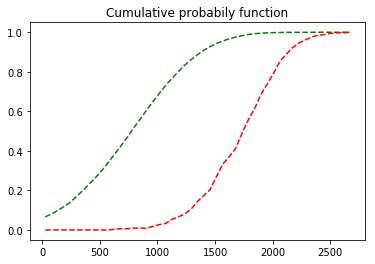

In [21]:
binsizes = []

for i in range(len(binedge)-1):
    binsizes.append( binedge[i+1]-binedge[i])
print(np.asarray(binsizes))

cumulative_p0 = []
cumulative_p1 = []
c0 = 0.
c1 = 0.
for i in range(len(binedge)-1):
    c0 += nondefhist1[i]*binsizes[i]
    c1 += defhist1[i]*binsizes[i]
    cumulative_p0.append(c0)
    cumulative_p1.append(c1)
cdf_x0 = np.asarray(cumulative_p0)
cdf_x1 = np.asarray(cumulative_p1)
plt.plot(x_grid, cdf_x0,'g--')
plt.plot(x_grid, cdf_x1, 'r--')
plt.title("Cumulative probabily function")
print("Cumulative probability ",[cumulative_p0[-1], cumulative_p1[-1]])

### A detour on the use of kernel density estimators

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


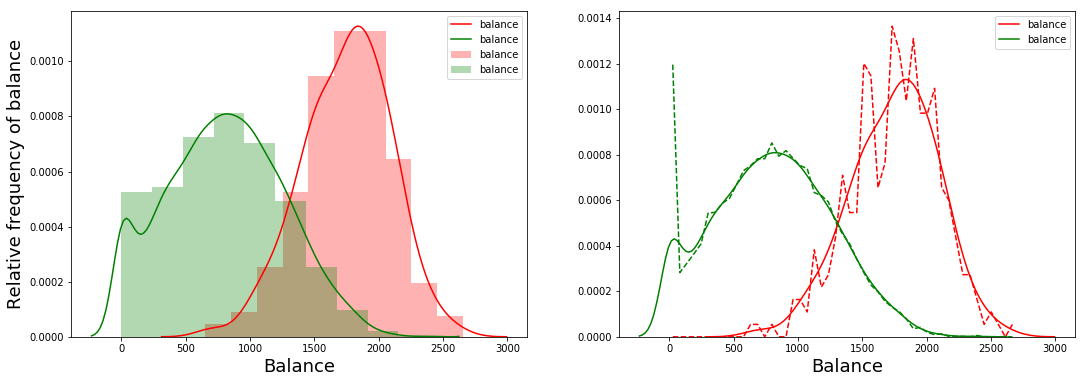

In [22]:
fig, axes = plt.subplots(figsize=(18,6),nrows=1, ncols=2)
axes[0].hist(defaulters.balance,color='r',alpha=0.3,density=True)
axes[0].hist(nondefaulters.balance,color='g',alpha=0.3,density=True)
axes[0].set_xlabel('Balance',fontsize=18)
axes[0].set_ylabel('Relative frequency of balance',fontsize=18)

# how would you convert a histogram into a pdf?
sns.kdeplot(defaulters.balance, color ='r', ax=axes[0]) # kernel density estimator (kde)
sns.kdeplot(nondefaulters.balance, color ='g', ax=axes[0]) # kde smooths histograms into pdfs



# rename the histograms to values p_x_condition = p(x|condition)
# also recall that we've renamed the values of 'balance' 
# for mid-pts of the bins x-grid


p_x_default = defhist1 
p_x_nondefault = nondefhist1 
axes[1].plot(x_grid, p_x_default, 'r--')
axes[1].plot(x_grid, p_x_nondefault, 'g--')
axes[1].set_xlabel('Balance', fontsize=18)

sns.kdeplot(defaulters.balance[1:], color ='r', ax=axes[1]) # kernel density estimator (kde)
sns.kdeplot(nondefaulters.balance[1:], color ='g', ax=axes[1]) # kde smooths histograms into pdfs

## Back to logistic regression: computing log-odds

For each bin we take a ratio of the probabilities of the defaulters (red) to the non-defaulters (green) counts. As there can be bins with no data points allocated, the ratio could be zero or unbounded, and the log-odds will be undefined. 

To prevent that from happening, we add a small number "eps" to each of the counts. We take "eps" to be small in order to not alter the ratios too much.

In [23]:
def logratio(a, b, eps=1e-14): 
    # take log ( ratio of probabilities of (y vs not-y) )   
    # add the eps, to prevent taking logs of 0 or infinity
    a=a+eps 
    b=b+eps
    return np.log(a/b)

# sigmoid 函数 输入x参数。输入拟合后得到的权重，然后得到最终logistics的曲线
def sigmoid(x):
    return 1/(1+np.exp(-x))

[ 1.96739534e-02 -3.46957391e+01]
Linear regression fit for log-odds on the left; sigmoidal transformation of linear fit on the right


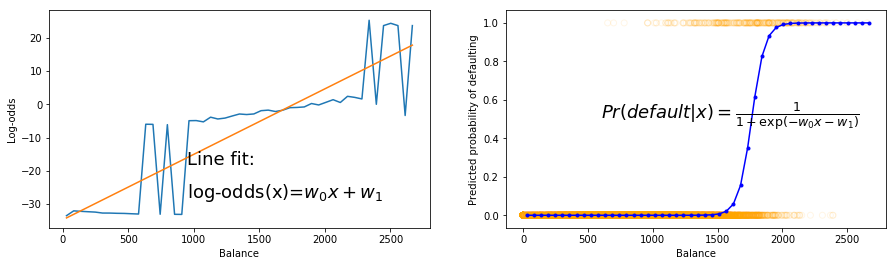

In [25]:
fig, axes = plt.subplots(figsize=(15,4),nrows=1, ncols=2)
# draw two plots
lodds=logratio(p_x_default,p_x_nondefault, 1e-16) + logratio(len(defaulters), len(nondefaulters))

lrfit=np.polyfit(x_grid, lodds, deg=1) 
# straight line fit。 直接使用这个去进行线性的拟合，目标值是lodds,所以其实也还是一个线性拟合。一次多项式拟合
# *********************** 这里也还是直接用poly直接进行拟合的。
# print(lrfit).  #多项式拟合的值

axes[0].plot(x_grid, lodds)
# plot log-odds "lodds" and also the straight line fit to it
# (lrfit[1], lrfit[0]) = (intercept, slope) 
axes[0].plot(x_grid,(lrfit[0]*x_grid + lrfit[1])) # lrfit[0] is the slope 
axes[0].set_xlabel('Balance')
axes[0].set_ylabel('Log-odds')
axes[0].text(950,-18, r'Line fit:', fontsize=18)
axes[0].text(950,-28, r'log-odds(x)=$w_0x+w_1$', fontsize=18)

axes[1].scatter(df.balance, df.default, facecolors='none',edgecolors='orange',alpha=0.1,marker='o')
axes[1].plot(x_grid,sigmoid(lrfit[0]*x_grid+lrfit[1]),'b.-')
axes[1].set_xlabel('Balance')
axes[1].set_ylabel('Predicted probability of defaulting')
axes[1].text(600,0.5, r'$Pr({default}|x)=\frac{1}{1+\exp(-w_0x-w_1)}$', fontsize=18)

# 还是逻辑回归更好一些。
print("Linear regression fit for log-odds on the left; sigmoidal transformation of linear fit on the right")